# NetCDF reader

## Importing libraries

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
#from mpl_toolkits.basemap import Basemap

## Function to find the index of the closest value

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

## Reading NetCFD

### Specify the file location

In [11]:
data = './temp-precip/era5-island-wind.nc'
#data = './temp-precip/era5-canada.nc'
ds = nc.Dataset(data)

### Metadata

In [12]:
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2023-04-10 19:44:47 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data6/adaptor.mars.internal-1681155798.054271-17300-16-62311554-0c4d-4c39-a9c0-c5d692924275.nc /cache/tmp/62311554-0c4d-4c39-a9c0-c5d692924275-adaptor.mars.internal-1681154776.0576692-17300-29-tmp.grib
    dimensions(sizes): longitude(57), latitude(25), time(3624)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 u10(time, latitude, longitude), int16 v10(time, latitude, longitude), int16 t2m(time, latitude, longitude), int16 sst(time, latitude, longitude), int16 sf(time, latitude, longitude), int16 smlt(time, latitude, longitude), int16 tcrw(time, latitude, longitude), int16 tp(time, latitude, longitude)
    groups: 


In [13]:
print(ds.__dict__)

{'Conventions': 'CF-1.6', 'history': '2023-04-10 19:44:47 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data6/adaptor.mars.internal-1681155798.054271-17300-16-62311554-0c4d-4c39-a9c0-c5d692924275.nc /cache/tmp/62311554-0c4d-4c39-a9c0-c5d692924275-adaptor.mars.internal-1681154776.0576692-17300-29-tmp.grib'}


### Extracting the data

In [20]:
LON = list(ds['longitude'][:])
LAT = list(ds['latitude'][:])

prcp = np.array(ds['tp'][:])
temp = np.array(ds['t2m'][:])
sst = np.array(ds['sst'])
smlt = np.array(ds['smlt'][:]) #m of water equivalent
sf = np.array(ds['sf'][:])
w = np.sqrt(np.array(ds['u10'][:])**2+np.array(ds['v10'][:])**2)
#sd = np.array(ds['sd'][:])
#rsn = np.array(ds['rsn'][:])

### Converting the time

In [21]:
time = np.array(ds['time'][:])
origin = datetime.datetime(1900,1,1)
T = []
for h in time :
    T.append(origin + datetime.timedelta(hours = float(h)))

### Extracting the data at a specific location (WGS84 coordinates)

In [22]:
#lat = 69.038
#lon = -105.273 # coordinates of the field work

lat = 64.413414     #64.188637 64.031566 
lon = -17.315158    #-17.820569  -17.637077

PREP = []
TEMP = []
SMLT = []
SF = []
SST = []
#SD = []
RSN = []
W = []

idxLat = find_nearest(LAT, lat)
idxLong = find_nearest(LON, lon)

for t in range(len(time)) :
    PREP.append(float(prcp[t][idxLat][idxLong]))
    TEMP.append(float(temp[t][idxLat][idxLong]))
    SST.append(float(sst[t][idxLat][idxLong]))
    SMLT.append(float(smlt[t][idxLat][idxLong]))
    SF.append(float(sf[t][idxLat][idxLong]))
    #SD.append(float(sd[t][idxLat][idxLong]))
    #RSN.append(float(rsn[t][idxLat][idxLong]))
    W.append(float(w[t][idxLat][idxLong]))


### Plotting

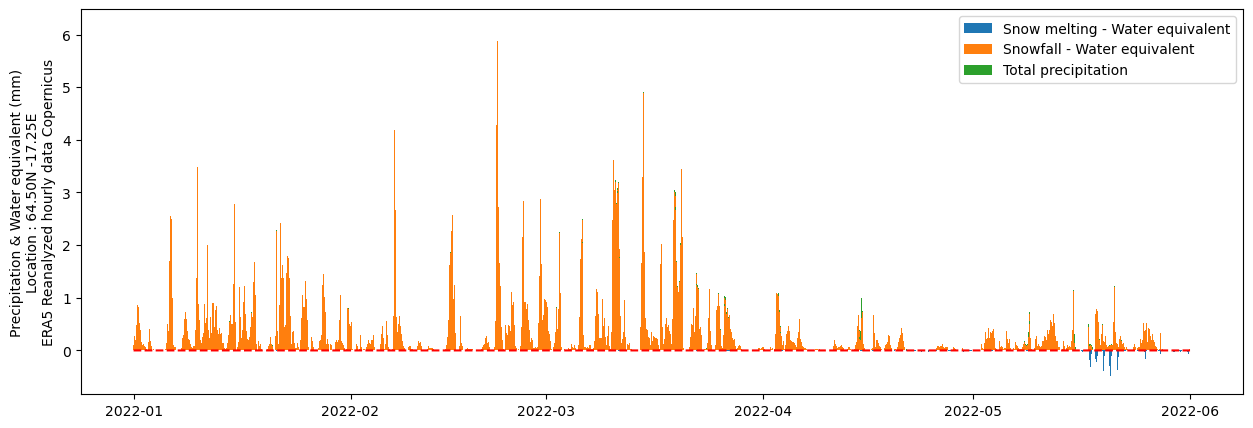

In [23]:
plt.figure(figsize=(15,5))

plt.plot(T, [0]*len(T), c='r', linestyle='--')

plt.bar(T,np.array(SMLT)*-1000, width= 0.05, label='Snow melting - Water equivalent')
plt.bar(T,np.array(SF)*1000, width= 0.05, label='Snowfall - Water equivalent')
plt.bar(T,(np.array(PREP)-np.array(SF))*1000, width= 0.05, bottom = np.array(SF)*1000,label='Total precipitation')

plt.ylabel('Precipitation & Water equivalent (mm)\nLocation : %0.2fN %0.2fE\nERA5 Reanalyzed hourly data Copernicus' %(LAT[idxLat], LON[idxLong]))

plt.legend()

plt.show()

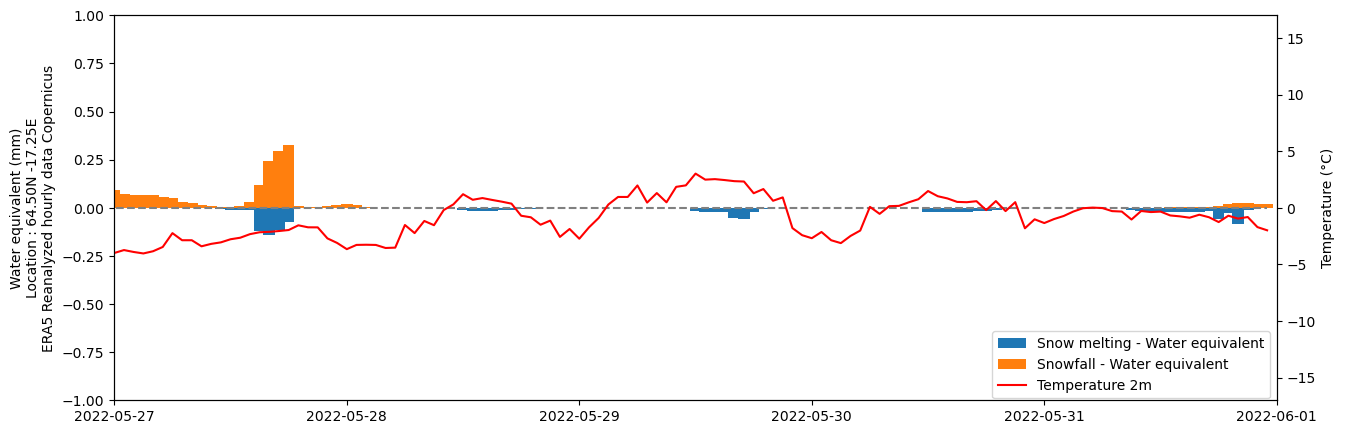

In [33]:
fig, ax1 = plt.subplots(figsize=(15,5))  

ax1.plot(T, [0]*len(T), c='grey', linestyle='--')

ax1.bar(T,np.array(SMLT)*-1000, width= 0.05, label='Snow melting - Water equivalent')
ax1.bar(T,np.array(SF)*1000, width= 0.05, label='Snowfall - Water equivalent')

ax1.set_xlim(np.datetime64("2022-05-27"), np.datetime64("2022-06-01"))
ax1.set_ylabel('Water equivalent (mm)\nLocation : %0.2fN %0.2fE\nERA5 Reanalyzed hourly data Copernicus' %(LAT[idxLat], LON[idxLong]))

ax1.set_ylim(-1,1)

# Adding Twin Axes

ax2 = ax1.twinx() 

ax2.set_ylim(-17,17)

ax2.set_ylabel('Temperature (°C)') 
ax2.plot(T, np.array(TEMP)-273.15, label='Temperature 2m', c='r')
#axset_ylim(-1,1) 
# Show plot

fig.legend(loc='lower right', bbox_to_anchor=(.9, .1))
plt.show()

(19139.0, 19144.0)

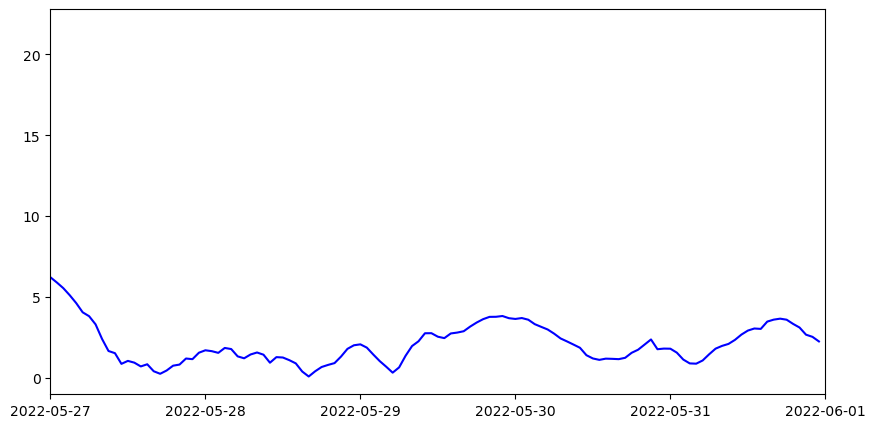

In [34]:
plt.figure(figsize=(10,5))
plt.plot(T, W, c='blue', linestyle='-')
plt.xlim(np.datetime64("2022-05-27"), np.datetime64("2022-06-01"))

### Comparing the Reanalysed era 5 data with weather station data

In [11]:
data = './temp-precip/era5-canada.nc'
ds = nc.Dataset(data)

LON = list(ds['longitude'][:])
LAT = list(ds['latitude'][:])

prcp = np.array(ds['tp'][:])
temp = np.array(ds['t2m'][:])
sst = np.array(ds['sst'])
smlt = np.array(ds['smlt'][:]) #m of water equivalent
sf = np.array(ds['sf'][:])
sd = np.array(ds['sd'][:])
rsn = np.array(ds['rsn'][:])

time = np.array(ds['time'][:])
origin = datetime.datetime(1900,1,1)
T = []
for h in time :
    T.append(origin + datetime.timedelta(hours = float(h)-7)) # --> -7h to match with the local time

In [12]:
lat = 69.038
lon = -105.273 # coordinates of the field work

#lat =    64.031566 #64.188637
#lon =   -17.637077 #-17.820569

PREP = []
TEMP = []
SMLT = []
SF = []
SST = []
SD = []
RSN = []

idxLat = find_nearest(LAT, lat)
idxLong = find_nearest(LON, lon)

for t in range(len(time)) :
    PREP.append(float(prcp[t][idxLat][idxLong]))
    TEMP.append(float(temp[t][idxLat][idxLong]))
    SST.append(float(sst[t][idxLat][idxLong]))
    SMLT.append(float(smlt[t][idxLat][idxLong]))
    SF.append(float(sf[t][idxLat][idxLong]))
    SD.append(float(sd[t][idxLat][idxLong]))
    RSN.append(float(rsn[t][idxLat][idxLong]))


#### Fieldwork data

In [13]:
field = pd.read_csv('./era-5_quality/Snow_Ice_temp.csv', delimiter=';', decimal=',')

In [14]:
field

,station,Date,heure,Ice depth (moyenne),Ice depth (std),Ice depth (median),Snow Cover(moyenne),Snow Cover(Std),Snow Cover(median),Temperature,Unnamed: 10
0,CB1,05-05-22,2022-05-05 12:00,189.312500,2.713393,190.00,8.291176,0.791406,8.50,-7.4,NaN
1,CB2,09-05-22,2022-05-09 12:05,188.350000,1.292070,189.00,8.850000,1.106797,8.75,-9.2,NaN
2,CB3,13-05-22,2022-05-13 13:00,191.833333,1.172604,192.00,7.833333,1.030776,8.00,-5.7,NaN
3,CB4,17-05-22,2022-05-17 12:10,191.300000,0.823273,191.00,7.700000,0.888194,7.50,-5.0,NaN
4,CB5,21-05-22,2022-05-21 12:30,195.950000,0.643342,196.00,7.350000,0.474342,7.00,-6.6,NaN
5,CB6,26-05-22,2022-05-26 12:20,189.550000,0.797566,190.00,7.000000,0.471405,7.00,-3.8,NaN
6,CB7,30-05-22,2022-05-30 13:00,193.812500,0.842509,193.75,9.562500,0.417261,9.50,-4.5,NaN


In [15]:
fieldtime = np.array(field.heure, dtype = np.datetime64)

#### Weather station

In [16]:
station = pd.read_csv('./era-5_quality/en_climate_hourly_NU_2400601_05-2022_P1H.csv')

In [17]:
station

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time (LST),Year,Month,Day,Time (LST),Temp (°C),...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,-105.14,69.11,CAMBRIDGE BAY A,2400601,2022-05-01 00:00,2022,5,1,00:00,-17.8,...,NaN,24.1,NaN,102.91,NaN,NaN,NaN,-26.0,NaN,NaN
1,-105.14,69.11,CAMBRIDGE BAY A,2400601,2022-05-01 01:00,2022,5,1,01:00,-17.6,...,NaN,24.1,NaN,102.90,NaN,NaN,NaN,-26.0,NaN,NaN
2,-105.14,69.11,CAMBRIDGE BAY A,2400601,2022-05-01 02:00,2022,5,1,02:00,-18.2,...,NaN,24.1,NaN,102.87,NaN,NaN,NaN,-27.0,NaN,Mainly Clear
3,-105.14,69.11,CAMBRIDGE BAY A,2400601,2022-05-01 03:00,2022,5,1,03:00,-18.3,...,NaN,24.1,NaN,102.85,NaN,NaN,NaN,-27.0,NaN,NaN
4,-105.14,69.11,CAMBRIDGE BAY A,2400601,2022-05-01 04:00,2022,5,1,04:00,-18.7,...,NaN,24.1,NaN,102.83,NaN,NaN,NaN,-29.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,-105.14,69.11,CAMBRIDGE BAY A,2400601,2022-05-31 19:00,2022,5,31,19:00,0.3,...,NaN,24.1,NaN,102.21,NaN,NaN,NaN,NaN,NaN,NaN
740,-105.14,69.11,CAMBRIDGE BAY A,2400601,2022-05-31 20:00,2022,5,31,20:00,0.0,...,NaN,24.1,NaN,102.25,NaN,NaN,NaN,-5.0,NaN,Mostly Cloudy
741,-105.14,69.11,CAMBRIDGE BAY A,2400601,2022-05-31 21:00,2022,5,31,21:00,-0.3,...,NaN,24.1,NaN,102.27,NaN,NaN,NaN,-5.0,NaN,NaN
742,-105.14,69.11,CAMBRIDGE BAY A,2400601,2022-05-31 22:00,2022,5,31,22:00,-1.5,...,NaN,24.1,NaN,102.31,NaN,NaN,NaN,-6.0,NaN,NaN


In [18]:
stt_temp = station['Temp (°C)'].ffill(downcast='infer')
stt_time = station['Date/Time (LST)'].astype(np.datetime64)

In [19]:
tmax = np.argmax(stt_temp)
print(stt_time[tmax])

2022-05-31 13:00:00


#### Comparison temperature 

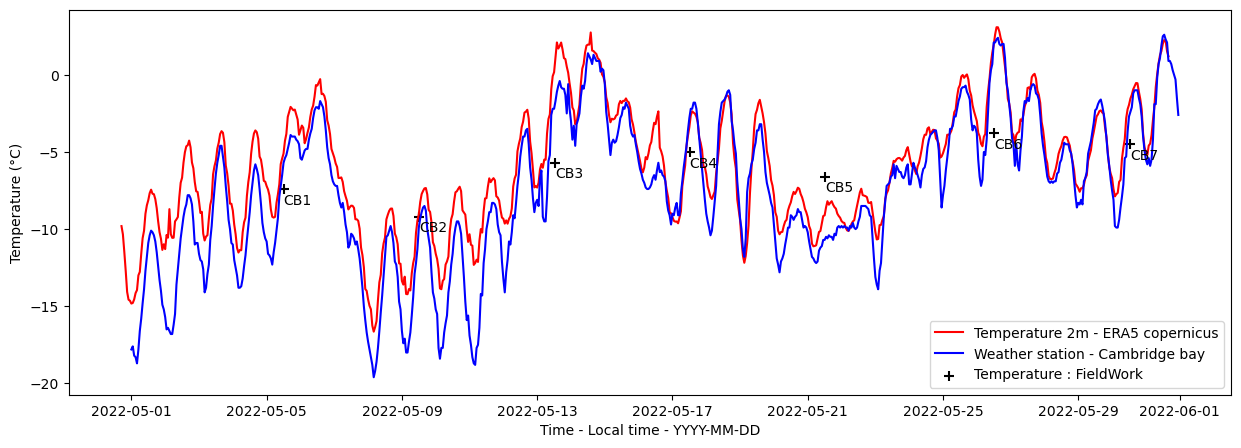

In [20]:
fig = plt.figure(figsize=(15,5))
plt.plot(np.array(T).astype(np.datetime64), np.array(TEMP)-273.15, label='Temperature 2m - ERA5 copernicus', c='r')
plt.plot(stt_time, stt_temp, c='blue', label='Weather station - Cambridge bay')
for data in enumerate(field.station) :
    plt.text(fieldtime[data[0]], field['Temperature'][data[0]]-1, data[1])
plt.scatter(fieldtime, field.Temperature, marker = '+', c='k', s=50, label='Temperature : FieldWork')
plt.legend()
plt.ylabel('Temperature (°C)')
plt.xlabel('Time - Local time - YYYY-MM-DD')
plt.savefig('./era-5_quality/mashmallow.png')

In [21]:
era5_temp = np.array(TEMP)-273.15
X = stt_temp[:-7]
Y = era5_temp[7:]
print(len(X), len(Y))

737 737


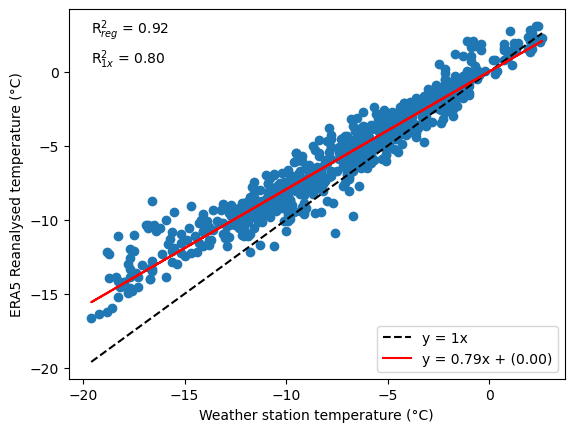

In [22]:
import sklearn.linear_model as sk
from sklearn.metrics import mean_squared_error, r2_score
era5_temp = Y
stt_temp = X
reg = sk.LinearRegression().fit(np.array(stt_temp).reshape(-1, 1), era5_temp.reshape(-1, 1))
r2 = reg.score(np.array(stt_temp).reshape(-1, 1), era5_temp.reshape(-1, 1))
r2_1x = r2_score(stt_temp,era5_temp)
m = reg.coef_
p = reg.intercept_
plt.scatter(stt_temp, era5_temp)
plt.text(np.min(stt_temp), np.max(stt_temp), 'R$^2_{reg}$ = %.2f' %r2)
plt.text(np.min(stt_temp), np.max(stt_temp)-2, 'R$^2_{1x}$ = %.2f' %r2_1x)
plt.plot([np.min(stt_temp),np.max(stt_temp)],[np.min(stt_temp),np.max(stt_temp)], c='k', ls = '--', label='y = 1x')
#plt.plot(stt_temp, reg1.predict(np.array(stt_temp).reshape(-1, 1)),c='yellow')
plt.plot(stt_temp, reg.predict(np.array(stt_temp).reshape(-1, 1)),c='r', label='y = %.2fx + (%.2f)' %(m, p))
plt.xlabel('Weather station temperature (°C)')
plt.ylabel('ERA5 Reanalysed temperature (°C)')
plt.legend(loc='lower right')
plt.savefig('./era-5_quality/choco-doux.png')

#### Comparison snow tickness

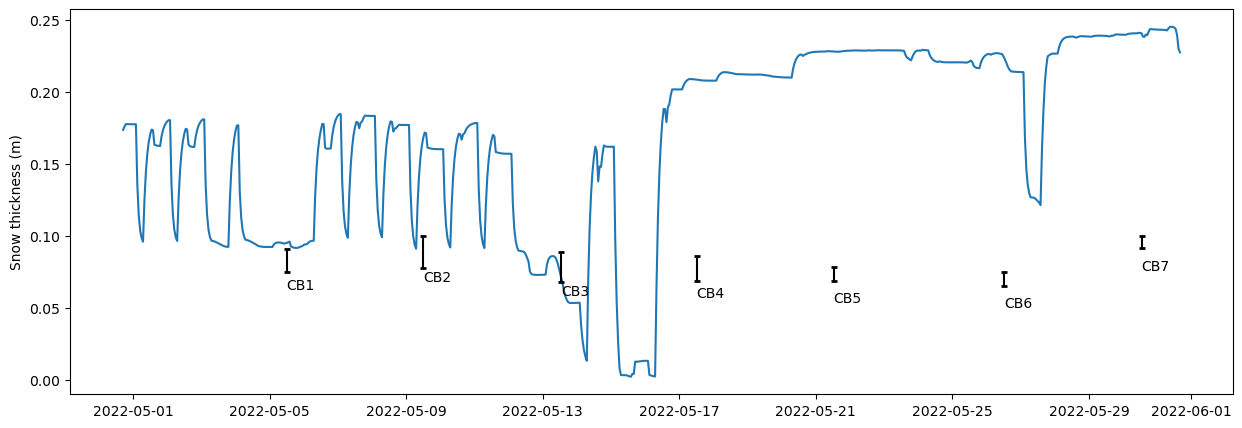

In [23]:
plt.figure(figsize=(15,5))
plt.plot(np.array(T).astype(np.datetime64),np.array(SD)/(np.array(RSN)/1000))
#for data in enumerate(field.station) :
#    plt.text(fieldtime[data[0]], field['Temperature'][data[0]]-1, data[1])
plt.errorbar(fieldtime, field['Snow Cover(moyenne)']/100, yerr = np.array(field['Snow Cover(Std)'])/100,linestyle='None', ecolor= 'k', capsize=2, capthick=2,label='ERA5 - Snow thickness (m)')
for data in enumerate(field.station) :
    plt.text(fieldtime[data[0]], field['Snow Cover(moyenne)'][data[0]]/100-.02, data[1])
plt.ylabel('Snow thickness (m)')
plt.savefig('./era-5_quality/glace-vanille.png')

### Doing a function

In [24]:
def cdf_weather(data, lat, lon, start, end) :
    #reading netcdf
    ds = nc.Dataset(data)
    #extracting data
    LON = list(ds['longitude'][:])
    LAT = list(ds['latitude'][:])

    prcp = np.array(ds['tp'][:])
    temp = np.array(ds['t2m'][:])
    sst = np.array(ds['sst'])
    smlt = np.array(ds['smlt'][:]) #m of water equivalent
    sf = np.array(ds['sf'][:])
    time = np.array(ds['time'][:])
    #converting time
    origin = datetime.datetime(1900,1,1)
    T = []
    for h in time :
        t = origin + datetime.timedelta(hours = float(h))
        if t > start and t < end :
            T.append(origin + datetime.timedelta(hours = float(h)))
        elif t > end :
            break

    PREP = []
    TEMP = []
    SMLT = []
    SF = []
    #finding the lat and lon
    idxLat = find_nearest(LAT, lat)
    idxLong = find_nearest(LON, lon)

    for t in range(len(time)) :
        PREP.append(float(prcp[t][idxLat][idxLong]))
        TEMP.append(float(temp[t][idxLat][idxLong]))
        SMLT.append(float(smlt[t][idxLat][idxLong]))
        SF.append(float(sf[t][idxLat][idxLong]))

    return PREP, TEMP, SMLT, SF

In [ ]:
data = './temp-precip/megnette_bis.nc'